<a href="https://colab.research.google.com/github/IanVlasov/NVidia_DL_in_CV/blob/lesson_4/Vlasov_Ian_HW04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семантическая Сегментация. Часть 3.

## Переключение версии TensorFlow

In [0]:
%tensorflow_version 2.x

In [0]:
import os
import skimage.io as io
import numpy as np

import tensorflow as tf

## Загрузка датасета COCO и COCO API

In [6]:
if 1:
    !mkdir -p data

    # !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
    # !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
    !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

    # !cd data && unzip -q train2017.zip
    # !cd data && unzip -q val2017.zip
    !cd data && unzip -q annotations_trainval2017.zip

    !cd data && git clone https://github.com/cocodataset/cocoapi
    !cd data/cocoapi/PythonAPI && make

--2020-06-03 06:50:10--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.16.148
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.16.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  30.6MB/s    in 8.6s    

2020-06-03 06:50:19 (28.0 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 12.74 MiB/s, done.
Resolving deltas: 100% (576/576), done.
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning

## Подготовка COCO API

In [0]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

In [7]:
def save_images(sublist):
  """
  Function to save only images for category "person" on drive
  """
  ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
  coco = COCO(ann_file_fpath)
  cat_ids = coco.getCatIds(catNms=['person'])
  if sublist == 'train':
    img_list = coco.getImgIds(catIds=cat_ids)[:5000]
  else:
    img_list = coco.getImgIds(catIds=cat_ids)[:500]

  try:
    for i, item in enumerate(img_list):
      img_id = int(item)
      img_data = coco.loadImgs(img_id)[0]
      img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

      img = io.imread(img_data['coco_url'])
      io.imsave(os.path.join(COCO_ROOT, img_fname), img)
      if i % 1000 == 0:
        print(i)
  except:
    print(f'downloaded {i} images')
  finally:
    return img_list[:i]

if 1:
  train_list = save_images('train')
  val_list = save_images('val')

loading annotations into memory...
Done (t=14.11s)
creating index...
index created!
0
1000
2000
3000
4000
loading annotations into memory...
Done (t=0.35s)
creating index...
index created!
0


In [0]:
def create_list(sublist):
  ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
  coco = COCO(ann_file_fpath)
  cat_ids = coco.getCatIds(catNms=['person'])
  img_set = set(coco.getImgIds(catIds=cat_ids))
  print(len(img_set))
  img_list = []

  for item in img_set:
      img_id = int(item)
      img_data = coco.loadImgs(img_id)[0]
      img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])
      
      if os.path.isfile(os.path.join(COCO_ROOT, img_fname)):
        img_list.append(item)
    
  return img_list


train_list = create_list('train')
val_list = create_list('val')  

## Универсальный класс Dataset для сегментации

In [0]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

## Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [0]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist, img_list):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        # self.img_list = self.coco.getImgIds(catIds=self.cat_ids)
        self.img_list = img_list

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [10]:
COCO_dataset_train = COCO_Dataset('train', train_list)
COCO_dataset_val = COCO_Dataset('val', val_list)

loading annotations into memory...
Done (t=13.63s)
creating index...
index created!
loading annotations into memory...
Done (t=0.44s)
creating index...
index created!


In [0]:
BATCH_SIZE = 64
NUM_EPOCHS = 20
INP_SIZE = 300

In [0]:
train_ds = COCO_dataset_train.train_dataset(epochs=1, inp_size=INP_SIZE, batch_size=BATCH_SIZE)
val_ds = COCO_dataset_val.val_dataset(inp_size=INP_SIZE, batch_size=BATCH_SIZE)

In [0]:
def build_model():
  
  x = tf.keras.layers.Input((INP_SIZE, INP_SIZE, 3))
  out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
  out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
  out = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')(out)
  out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
  out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
  out = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')(out)
  out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
  out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
  out_enc_mid = out
  out = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')(out)
  out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
  out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
  out = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')(out)
  out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
  out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
  #aspp
  out1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')(out)
  out2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')(out)
  out3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')(out)
  out4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')(out)
  aspp_out = tf.concat([out1, out2, out3, out4], axis=3)
  out = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')(aspp_out)

  out = tf.image.resize(out, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BILINEAR)
  out_enc_mid = tf.keras.layers.Conv2D(48, (1, 1), padding='same', activation='relu')(out_enc_mid)

  out = tf.concat([out, out_enc_mid], axis=3)

  out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
  out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
  out = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation=None)(out)

  out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BILINEAR)
  out = tf.nn.sigmoid(out)

  return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

In [14]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss)

hist = model.fit(train_ds, epochs=NUM_EPOCHS, validation_data=val_ds)

Epoch 1/20
78/78 [==============================] - 166s 2s/step - loss: 1.0003 - val_loss: 0.4758
Epoch 2/20
78/78 [==============================] - 170s 2s/step - loss: 0.4529 - val_loss: 0.4499
Epoch 3/20
78/78 [==============================] - 169s 2s/step - loss: 0.4373 - val_loss: 0.4229
Epoch 4/20
78/78 [==============================] - 170s 2s/step - loss: 0.4052 - val_loss: 0.3951
Epoch 5/20
78/78 [==============================] - 170s 2s/step - loss: 0.3955 - val_loss: 0.4044
Epoch 6/20
78/78 [==============================] - 170s 2s/step - loss: 0.3846 - val_loss: 0.3702
Epoch 7/20
78/78 [==============================] - 170s 2s/step - loss: 0.3702 - val_loss: 0.3669
Epoch 8/20
78/78 [==============================] - 170s 2s/step - loss: 0.3598 - val_loss: 0.3451
Epoch 9/20
78/78 [==============================] - 171s 2s/step - loss: 0.3555 - val_loss: 0.3521
Epoch 10/20
78/78 [==============================] - 170s 2s/step - loss: 0.3374 - val_loss: 0.3534
Epoch 11/

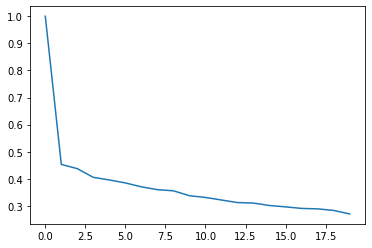

In [15]:
import matplotlib.pyplot as plt
import imageio


plt.plot(hist.history['loss'])

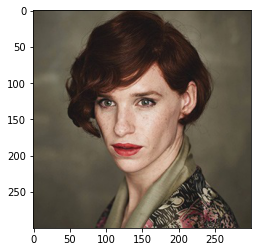

In [16]:
img = imageio.imread('test.jpg')
img = img.astype(np.float32) / 255.
_=plt.imshow(img)

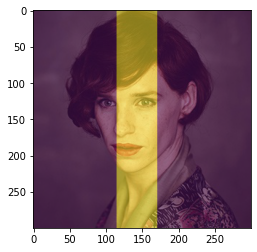

In [17]:
out = model.predict(img[None, ...])[0, ...]
seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
plt.imshow(img*0.5 + seg_map_clr*0.5)
plt.show()

Видно, что сеть что-то выучила, необходимо больше эпох обучения и больше фотографии + помогла бы аугментация. К сожалению, из-за проблем с коннектом к колабу обучить на больших объемах не получилось